In [1]:
import os
import torch
import random
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
import timm
import matplotlib.pyplot as plt
from tqdm import tqdm

d:\project\fresh-eye-fish-clasifier-final\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seed untuk reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

In [3]:
data_dir = 'dataset/train'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

dataset = ImageFolder(data_dir, transform=transform)
class_names = dataset.classes
print(f"Class: {class_names}, Jumlah data: {len(dataset)}")

Class: ['Segar', 'TidakSegar'], Jumlah data: 5696


In [4]:
targets = [label for _, label in dataset]
class_count = np.bincount(targets)
class_weights = 1. / class_count
sample_weights = [class_weights[label] for label in targets]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [5]:
batch_size = 32

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('tf_efficientnetv2_b0', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 2)
model = model.to(device)

# Loss dan Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [7]:
train_acc_history = []
train_loss_history = []

def train_model(model, loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0
        loop = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loop.set_postfix(loss=loss.item(), acc=100*correct/total)
        
        epoch_loss = running_loss / len(loader)
        epoch_acc = correct / total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        print(f"[{epoch+1}] Loss: {epoch_loss:.4f} | Acc: {epoch_acc*100:.2f}%")

train_model(model, train_loader, criterion, optimizer, epochs=30)

[1] Loss: 0.6302 | Acc: 64.06%


[2] Loss: 0.5199 | Acc: 74.35%


[3] Loss: 0.4805 | Acc: 77.25%


[4] Loss: 0.4549 | Acc: 78.81%


[5] Loss: 0.4393 | Acc: 79.86%


[6] Loss: 0.4102 | Acc: 82.22%


[7] Loss: 0.4032 | Acc: 82.16%


[8] Loss: 0.4080 | Acc: 82.04%


[9] Loss: 0.3850 | Acc: 83.67%


[10] Loss: 0.3959 | Acc: 83.22%


[11] Loss: 0.3980 | Acc: 82.32%


[12] Loss: 0.3888 | Acc: 83.08%


[13] Loss: 0.3735 | Acc: 84.15%


[14] Loss: 0.3777 | Acc: 83.50%


[15] Loss: 0.3770 | Acc: 83.55%


[16] Loss: 0.3777 | Acc: 84.06%


[17] Loss: 0.3683 | Acc: 84.15%


[18] Loss: 0.3688 | Acc: 84.09%


[19] Loss: 0.3790 | Acc: 83.67%


[20] Loss: 0.3644 | Acc: 84.73%


[21] Loss: 0.3736 | Acc: 83.88%


[22] Loss: 0.3671 | Acc: 84.34%


[23] Loss: 0.3671 | Acc: 84.48%


[24] Loss: 0.3633 | Acc: 84.34%


[25] Loss: 0.3600 | Acc: 84.83%


[26] Loss: 0.3714 | Acc: 84.06%


[27] Loss: 0.3554 | Acc: 85.46%


[28] Loss: 0.3569 | Acc: 85.09%


[29] Loss: 0.3634 | Acc: 84.71%


[30] Loss: 0.3665 | Acc: 84.45%


In [8]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(confusion_matrix(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=class_names))

[[1986  873]
 [   4 2833]]
              precision    recall  f1-score   support

       Segar       1.00      0.69      0.82      2859
  TidakSegar       0.76      1.00      0.87      2837

    accuracy                           0.85      5696
   macro avg       0.88      0.85      0.84      5696
weighted avg       0.88      0.85      0.84      5696



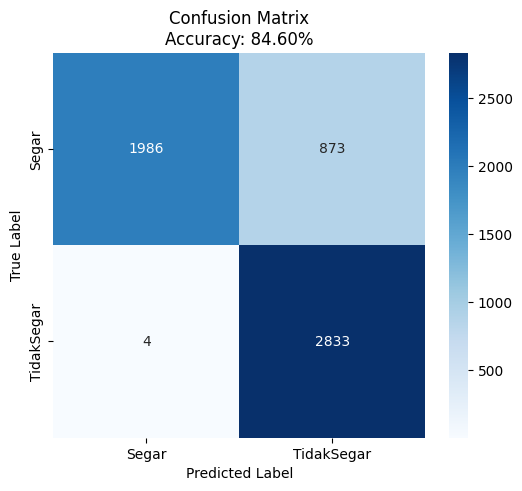

In [15]:
from sklearn.metrics import accuracy_score  # Add this import if not already present
import seaborn as sns  # Fix: import seaborn

cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix\nAccuracy: {acc*100:.2f}%')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

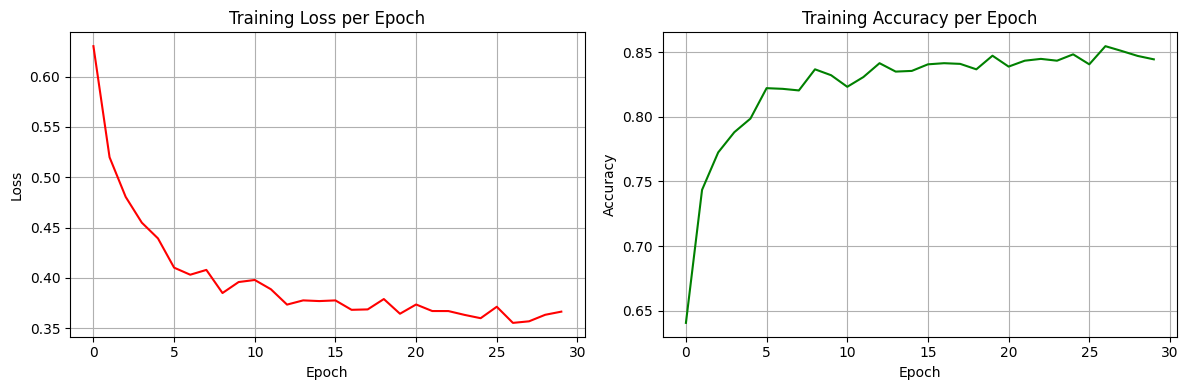

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Loss', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Accuracy', color='green')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
torch.save(model.state_dict(), "efficientnetv2_ikan.pt")
print("Model disimpan sebagai efficientnetv2_ikan.pt")

Model disimpan sebagai efficientnetv2_ikan.pt
